In [16]:
from enum import Enum
from dataclasses import dataclass
import random
import math

# Visualize schedule
To debug and compare the results to the solution found in https://developers.google.com/optimization/scheduling/job_shop#a_solution_for_the_problem, we create a Gantt chart. (used here only for populated-based algorithm)

In [17]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

def plot_schedule(data):
    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = colormaps.get_cmap('tab20')
    for m_idx, machine_tasks in enumerate(data):
        for task in machine_tasks:
            ax.broken_barh([(task.offset, task.duration)], (m_idx - 0.4, 0.8), 
                            facecolors=cmap(task.job_index % 20), edgecolor='black', linewidth=1) 
            ax.text(task.offset + task.duration/2, m_idx, f'J{task.job_index}({task.task_index})', 
                    ha='center', va='center', color='black', fontsize=9) 

    ax.set_xlabel('Time Units')
    ax.set_ylabel('Machine Index')
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels([f'Machine {i}' for i in range(len(data))]
)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    plt.title('Job Shop Schedule Visualization')
    plt.tight_layout()
    plt.show()

# Parse input file to extract job information

In [18]:
def parse_instance(file_name, instance_name):
    with open(file_name,'r') as f:
        lines=f.readlines()
    start_idx=-1
    for i,line in enumerate(lines):
       if f"instance {instance_name}" in line.strip():
           start_idx=i
           break
    if start_idx == -1:
        raise ValueError(f"Instance {instance_name} not found in file {file_name}.")
    skip_line=start_idx+4
    num_jobs,num_machines=map(int, lines[skip_line].split())
    jobs_data=[]
    for i in range(1, num_jobs+1):
        line_content=lines[skip_line+i].strip().split()
        job_data_copy=[]
        for j in range(0, len(line_content),2):
            machine=int(line_content[j])
            time=int(line_content[j+1])
            job_data_copy.append((machine,time))
        jobs_data.append(job_data_copy)
    return num_machines, num_jobs, jobs_data

# Population-Based algorithm

## Classes to make the code more readable

In [19]:
class Strategy(Enum):
    PLUS = 1
    COMMA = 2

@dataclass
class Task:
    machine_index: int
    job_index: int
    task_index: int
    duration: int
    offset: int

class Candidate:
    def __init__(self, schedule: list[list[Task]]) -> None:
        self.schedule = schedule
        self.time = max(machine[-1].duration + machine[-1].offset for machine in schedule)

    def __repr__(self) -> str:
        return f"{self.time} {[[(task.job_index, task.task_index, task.duration, task.offset) for task in machine] for machine in self.schedule]}"

## Create candidate solutions by populating schedule
Randomly select an active job and schedule it on the required machine. If no job can be scheduled since the previous jobs are not yet completed, we wait for a random job instead and then schedule it.

In [20]:
def create_candidate(schedule, machine_ready_times, task_ready_times, next_task_by_job, active_jobs, data) -> Candidate:
    # populate schedule for each machine
    while active_jobs:
        selected_job = random.choice(active_jobs)
        selected_task = next_task_by_job[selected_job]

        # queue task for required machine
        machine, duration = data[selected_job][selected_task]
        offset = max(task_ready_times[selected_job], machine_ready_times[machine])
        #print(selected_job, selected_task, "->", machine, duration, ": starts at", offset, "ends at", offset + duration)
        task_info = Task(machine, selected_job, selected_task, duration, offset)
        schedule[machine].append(task_info)

        task_ready_times[selected_job] = duration + offset
        machine_ready_times[machine] += duration

        # check if this was the last task for this job
        next_task_by_job[selected_job] += 1
        if next_task_by_job[selected_job] >= len(data[selected_job]):
            active_jobs.remove(selected_job)
    
    return Candidate(schedule)

## Set up the variables for the initial candidates
To create new candidates, we need to initialize all variables to default values.

In [21]:
def get_initial_candidates(m, num_machines, num_jobs, data):
    candidates = list[Candidate]()
    for _ in range(m):
        # create a schedule for each machine
        schedule = [list[Task]() for _ in range(num_machines)]
        # for each machine, store when it becomes available again
        machine_ready_times = [0] * num_machines
        task_ready_times = [0] * num_jobs
        # for each job, store the index of the next task to schedule
        next_task_by_job = [0] * len(data)
        # jobs that still have tasks left
        active_jobs = [job_index for job_index, _ in enumerate(data)]
        candidate = create_candidate(schedule, machine_ready_times, task_ready_times, next_task_by_job, active_jobs, data)
        candidates.append(candidate)
    return candidates

## Mutate parents to create children/ offsprings
We expect $l / len(parents)$ to be an integer so that the correct number of children are created.
For the mutation algorithm, we randomly select a job and cut off all jobs that appear after the start time of the selected job. We then re-populate the schedule from that point on by again randomly selecting active jobs.

In [22]:
def mutate(parents: list[Candidate], l, num_machines, num_jobs, data) -> list[Candidate]:
    children_per_parent = l / len(parents)
    children = list[Candidate]()
    for parent in parents:
        for _ in range(int(children_per_parent)):
            # select random task to split at
            jobs = len(parent.schedule)
            tasks = len(parent.schedule[0])
            random_job = random.randint(0, jobs - 1)
            random_task = random.randint(0, tasks - 1)
            chosen_task = parent.schedule[random_job][random_task]
            schedule = [list[Task]() for _ in range(num_machines)]
            
            # copy parent schedule to child
            for i in range(jobs):
                for j in range(tasks):
                    if parent.schedule[i][j].offset <= chosen_task.offset:
                        schedule[i].append(parent.schedule[i][j])
            
            # reconstruct state from the partial schedule
            machine_ready_times = [0] * num_machines
            task_ready_times = [0] * num_jobs
            next_task_by_job = [0] * num_jobs
            
            # scan through copied tasks to rebuild state
            for i, machine_tasks in enumerate(schedule):
                if machine_tasks:
                    last_task = machine_tasks[-1]
                    machine_ready_times[i] = last_task.offset + last_task.duration
                
            # find the highest task_index for each job
            for job_index in range(num_jobs):
                max_task_index = -1
                for machine_tasks in schedule:
                    for task in machine_tasks:
                        if task.job_index == job_index and task.task_index > max_task_index:
                            max_task_index = task.task_index
                            task_ready_times[job_index] = task.offset + task.duration
                next_task_by_job[job_index] = max_task_index + 1
            
            # only jobs with remaining tasks are active
            active_jobs = [job_index for job_index in range(num_jobs) if next_task_by_job[job_index] < len(data[job_index])]
            
            candidate = create_candidate(schedule, machine_ready_times, task_ready_times, next_task_by_job, active_jobs, data)
            children.append(candidate)
    return children

## Population strategies
Here, we solve the problem by iterating over all generations and create new offsprings and select the next generation depending on the strategy.

In [23]:
def solve(strategy: Strategy, m, l, max_generations, num_machines, num_jobs, data) -> Candidate:
    parents = get_initial_candidates(m, num_machines, num_jobs, data)
    offsprings = list[Candidate]()
    for _ in range(max_generations):
        offsprings = mutate(parents, l, num_machines, num_jobs, data)
        if strategy == Strategy.PLUS:
            offsprings.extend(parents)
            offsprings.sort(key=lambda x: x.time) 
            parents = []
            for i in range(m):
                parents.append(offsprings[i])
        elif strategy == Strategy.COMMA:
            offsprings.sort(key=lambda x: x.time) 
            parents = []
            for i in range(m):
                parents.append(offsprings[i])
    parents.sort(key=lambda x: x.time) 
    return parents[0]

803 [[(16, 0, 13, 0), (12, 0, 10, 13), (7, 0, 32, 23), (19, 2, 43, 128), (10, 3, 42, 112), (6, 0, 27, 140), (0, 2, 21, 167), (13, 1, 41, 188), (1, 4, 40, 271), (18, 4, 27, 319), (8, 4, 20, 296), (5, 8, 24, 316), (3, 6, 34, 340), (17, 11, 48, 406), (2, 6, 19, 476), (14, 12, 38, 441), (11, 12, 15, 607), (9, 16, 47, 691), (4, 18, 21, 749), (15, 17, 48, 675)], [(5, 2, 18, 84), (2, 1, 12, 34), (16, 4, 36, 233), (10, 8, 45, 255), (1, 7, 20, 386), (12, 6, 28, 260), (9, 4, 22, 298), (0, 10, 31, 363), (15, 8, 22, 437), (11, 8, 26, 487), (7, 12, 33, 562), (17, 17, 38, 635), (18, 17, 40, 701), (13, 11, 31, 500), (8, 9, 32, 474), (19, 16, 42, 680), (6, 14, 17, 565), (4, 11, 46, 537), (14, 14, 29, 555), (3, 13, 48, 584)], [(15, 3, 37, 187), (12, 5, 49, 211), (13, 5, 43, 313), (11, 3, 28, 203), (10, 11, 13, 368), (18, 11, 18, 574), (17, 14, 32, 538), (14, 10, 35, 342), (8, 8, 47, 427), (6, 11, 21, 478), (3, 10, 48, 448), (19, 14, 28, 617), (1, 13, 19, 532), (5, 16, 24, 536), (2, 14, 44, 712), (7, 18

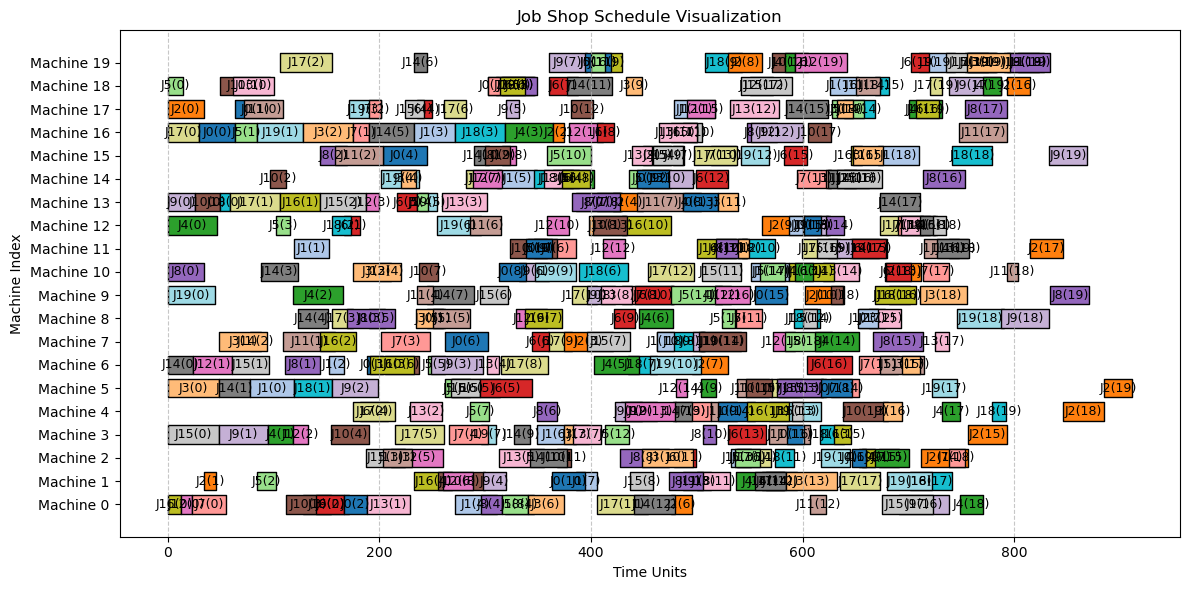

In [24]:
m = 10
l = 100
max_gens = 100

num_machines, num_jobs, data = parse_instance("jobshop_hackathon_instance.txt", "a")
candidate = solve(Strategy.PLUS, m, l, max_gens, num_machines, num_jobs, data)
print(candidate)
plot_schedule(candidate.schedule)

# Trajectory-based algorithm

## Helper Functions
This functions are meant to help in the algorithm part, by initializing the sequence and creating neighbours

In [25]:
def initialize_sequence(num_machines,num_jobs):
 sequence=[]
 for i in range(num_jobs):
    sequence.extend([i]*num_machines)
 random.shuffle(sequence)
 return sequence
def get_neighbour_annealing(sequence):
    neighbour=list(sequence)
    idx1,idx2=random.sample(range(len(neighbour)), 2)
    neighbour[idx1],neighbour[idx2]=neighbour[idx2],neighbour[idx1]
    return neighbour 
def get_neighbour_tabu(sequence):
    neighbour=list(sequence)
    idx1,idx2=random.sample(range(len(neighbour)), 2)
    neighbour[idx1],neighbour[idx2]=neighbour[idx2],neighbour[idx1]
    return neighbour, (idx1,idx2) 

# Makespan
This is the function that calculates the makespan.
We basically take the current operation from our sequence and see what machine is assigned to it and what is the machine's time to do that operation. The start time for the free machine is when the machine finishes its job and when the job is free to move on to the next step.After iterating through the whole steps of the sequence we return the biggest value of machine_free_time. The reason is, that the sequnce ends when the biggest time ends.

In [26]:
def calculate_makespan(sequence, num_machines, num_jobs, data):
    machine_free_time=[0]*num_machines
    job_op_index_next_time=[0]*num_jobs
    job_current_operation=[0]*num_jobs
    for job_id in sequence:
        op_current=job_current_operation[job_id]
        if op_current>= len(data[job_id]):
            continue
        machine_id,duration=data[job_id][op_current]
        start_time=max(machine_free_time[machine_id], job_op_index_next_time[job_id])
        end_time=start_time+duration
        machine_free_time[machine_id]=end_time
        job_op_index_next_time[job_id]=end_time
        job_current_operation[job_id]+=1
    return max(machine_free_time)

## Simulated Annealing
This is the simulate annealing algorithm. The way I thought of it is the same way it was presented in the lecture.
We have a Temperature T and a cooling rate, through which we control how sensitive the algorithm is to wrong choices.Through each iteration we take 2 indices from our current sequence randomly and swap their places, thus obtaining a new sequence and computing their makespan. If their makespan proves useful we keep the current sequence and makespan and compare them to the best ones.

In [27]:
def simulate_annealing(data,num_machines,num_jobs,num_iterations):
    current_seq=initialize_sequence(num_machines,num_jobs)
    current_makespan=calculate_makespan(current_seq,num_machines,num_jobs,data)
    best_seq=list(current_seq)
    best_makespan=current_makespan
    history_best_makespan=[]
    history_current_makespan=[]
    T=5000.0
    cooling_rate=0.9999
    for i in range(num_iterations):
        neighbor=get_neighbour_annealing(current_seq)
        neighbor_makepsan=calculate_makespan(neighbor,num_machines,num_jobs,data)
        diff=neighbor_makepsan-current_makespan
        if diff<0 or random.random()<math.exp(-diff/T):
            current_seq=neighbor
            current_makespan=neighbor_makepsan
        if current_makespan<best_makespan:
            best_seq=list(current_seq)
            best_makespan=current_makespan
        T*=cooling_rate
        history_best_makespan.append(best_makespan)
        history_current_makespan.append(current_makespan)
    return best_makespan,best_seq,history_best_makespan,history_current_makespan

## Tabu Search Algorithm 
This is the tabu search algorithm. For each iteration we swap indexes for a given number of times, in this case 50 times and add in a list the current sequence, the makespan and the pairs of indexes. After this we sort the list in ascending order and verify if move(the pair of indexes) is not in the tabulist or if the current maklespan is better than the best makespan. 
We also make use of Aspiration, by letting the algorithm choose a candidate that even though is in the tabu list, if it is better than everything we have seen, we still have to take it as a solution. The rest of the algorithm is fairly similar to the annealing, except that we also have to check if the size of the list has overtaken the size of the tabu

In [28]:
def tabu_search(data, num_machines, num_jobs,Iterations, tabu_size):
    current_seq=initialize_sequence(num_machines,num_jobs)
    current_makespan= calculate_makespan(current_seq,num_machines,num_jobs,data)
    best_seq=list(current_seq)
    best_makespan=current_makespan
    tabu_list=[]
    history_best_makespan=[]
    history_current_makespan=[]
    for i in range(Iterations):
        neighbor=[]
        for j in range(50):
            neighbor_copy,move=get_neighbour_tabu(current_seq)
            makespan=calculate_makespan(neighbor_copy,num_machines,num_jobs,data)
            neighbor.append((neighbor_copy,makespan,move))
        neighbor.sort(key=lambda x:x[1])
        for neighbor, makepsan,move in neighbor:
            if move not in tabu_list or makepsan<best_makespan:
                current_seq=neighbor
                current_makespan=makepsan
                tabu_list.append(move)
                if len(tabu_list)>tabu_size:
                    tabu_list.pop(0)
                if current_makespan<best_makespan:
                    best_seq=current_seq
                    best_makespan=current_makespan
                break
        history_best_makespan.append(best_makespan)
        history_current_makespan.append(current_makespan)
    return best_makespan,best_seq,history_best_makespan,history_current_makespan

## Visualization of Annealing

--- Testing Simulated Annealing on a ---
Jobs: 20, Machines: 20
Initial Random Makespan: 2009

--- Results ---
Best Makespan Found: 1057
Improvement: 952 units
Time Taken: 3.6549 seconds
Sequence: [12, 13, 9, 2, 16, 14, 4, 8, 17, 15, 8, 6, 8, 18, 3, 10, 15, 5, 2, 9, 3, 7, 0, 12, 10, 8, 11, 4, 2, 7, 11, 12, 18, 3, 17, 3, 6, 9, 15, 6, 18, 17, 13, 10, 14, 13, 6, 18, 12, 5, 10, 12, 1, 16, 11, 8, 15, 7, 0, 10, 7, 9, 14, 0, 2, 15, 7, 15, 11, 7, 9, 3, 5, 1, 0, 6, 5, 19, 8, 18, 13, 12, 15, 0, 12, 9, 14, 3, 1, 15, 13, 18, 12, 2, 11, 19, 14, 0, 3, 10, 19, 14, 13, 5, 2, 16, 17, 19, 12, 9, 6, 13, 10, 18, 0, 15, 10, 18, 11, 19, 17, 10, 18, 10, 3, 16, 3, 7, 12, 1, 1, 4, 1, 17, 13, 3, 4, 7, 17, 17, 7, 3, 1, 15, 5, 8, 6, 2, 11, 16, 7, 9, 15, 2, 19, 5, 9, 9, 11, 7, 11, 14, 12, 11, 0, 16, 10, 8, 7, 6, 11, 17, 19, 19, 10, 14, 1, 16, 2, 13, 0, 3, 16, 2, 8, 15, 7, 0, 12, 12, 4, 11, 17, 9, 18, 16, 13, 1, 3, 10, 5, 5, 14, 19, 2, 16, 7, 9, 2, 5, 6, 12, 13, 5, 6, 5, 15, 1, 14, 11, 4, 17, 17, 19, 15, 14, 9, 12,

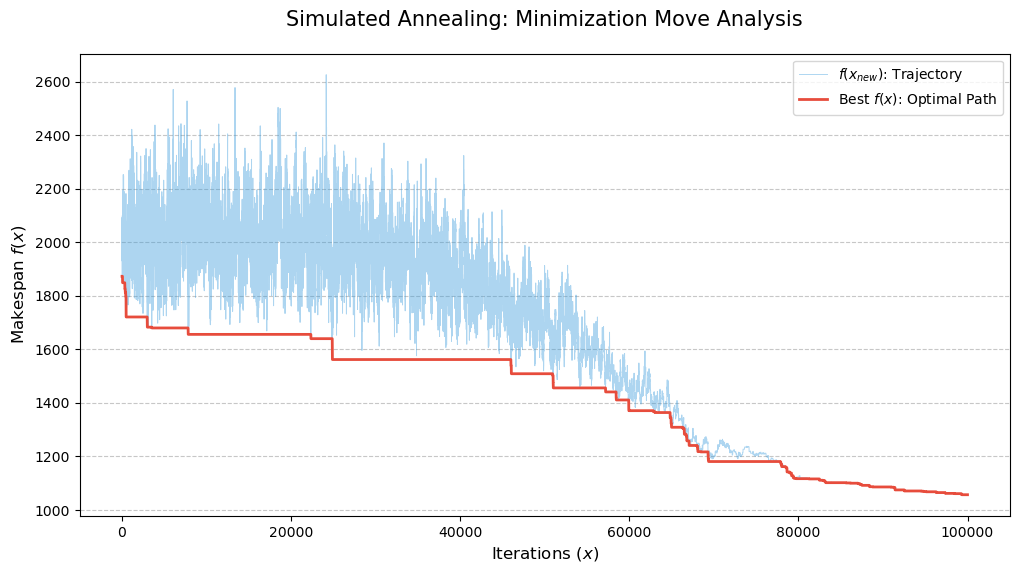

In [29]:
from jobshop_trajectory_based import*
import matplotlib.pyplot as plt
INSTANCE_NAME = "a"
FILENAME = "jobshop_hackathon_instance.txt"
ITERATIONS=100000
def run_test():
    try:
        num_jobs, num_machines, data = parse_instance(FILENAME, INSTANCE_NAME)
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    print(f"--- Testing Simulated Annealing on {INSTANCE_NAME} ---")
    print(f"Jobs: {num_jobs}, Machines: {num_machines}")
    
    random_seq = initialize_sequence(num_machines, num_jobs)
    random_makespan = calculate_makespan(random_seq, num_machines, num_jobs, data)
    print(f"Initial Random Makespan: {random_makespan}")

    start_time = time.time()
    best_makespan, best_sequence,history_best_makespan,history_current_makespan = simulate_annealing(data, num_machines, num_jobs,ITERATIONS)
    end_time = time.time()
    duration = end_time - start_time

    print("\n--- Results ---")
    print(f"Best Makespan Found: {best_makespan}")
    print(f"Improvement: {random_makespan - best_makespan} units")
    print(f"Time Taken: {duration:.4f} seconds")
    print(f"Sequence: {best_sequence}")

    plt.figure(figsize=(12, 6))
    plt.plot(history_current_makespan, label='$f(x_{new})$: Trajectory', color='#3498db', alpha=0.4, linewidth=0.7)
    
    plt.plot(history_best_makespan, label='Best $f(x)$: Optimal Path', color='#e74c3c', linewidth=2)
    plt.title('Simulated Annealing: Minimization Move Analysis', fontsize=15, pad=20)
    plt.xlabel('Iterations ($x$)', fontsize=12)
    plt.ylabel('Makespan $f(x)$', fontsize=12)
    
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
run_test()

## Visualization of tabu

--- Testing Tabu Search on a ---
Best Makespan: 1132
Best Sequence: [3, 13, 3, 4, 9, 10, 6, 17, 5, 19, 0, 17, 12, 19, 14, 4, 18, 15, 1, 4, 16, 12, 6, 13, 11, 6, 14, 8, 8, 2, 13, 10, 2, 6, 15, 12, 18, 17, 4, 3, 1, 6, 5, 13, 6, 10, 1, 9, 12, 10, 13, 9, 12, 18, 4, 17, 5, 18, 15, 11, 11, 7, 6, 14, 13, 13, 3, 4, 12, 11, 5, 10, 8, 2, 0, 16, 3, 10, 5, 14, 13, 13, 19, 0, 9, 18, 9, 8, 8, 4, 10, 4, 10, 16, 13, 17, 7, 6, 19, 19, 7, 4, 14, 15, 17, 1, 14, 19, 16, 2, 7, 1, 5, 3, 4, 9, 2, 12, 18, 2, 8, 10, 18, 14, 12, 9, 19, 11, 13, 6, 10, 5, 12, 18, 11, 3, 4, 9, 4, 6, 8, 4, 5, 16, 7, 0, 13, 3, 12, 5, 15, 15, 7, 0, 11, 1, 17, 3, 1, 18, 1, 15, 16, 10, 12, 8, 9, 12, 7, 0, 14, 8, 5, 9, 17, 18, 3, 19, 11, 15, 9, 13, 16, 1, 18, 3, 12, 0, 17, 17, 7, 10, 4, 14, 9, 3, 16, 2, 18, 10, 4, 3, 6, 5, 16, 2, 0, 11, 1, 0, 6, 15, 17, 0, 13, 6, 4, 7, 11, 9, 15, 14, 8, 3, 1, 2, 1, 14, 13, 19, 13, 5, 2, 12, 7, 14, 11, 16, 5, 10, 16, 15, 9, 19, 5, 8, 10, 19, 15, 2, 12, 17, 10, 13, 2, 19, 8, 17, 15, 3, 10, 18, 8, 12, 7, 0

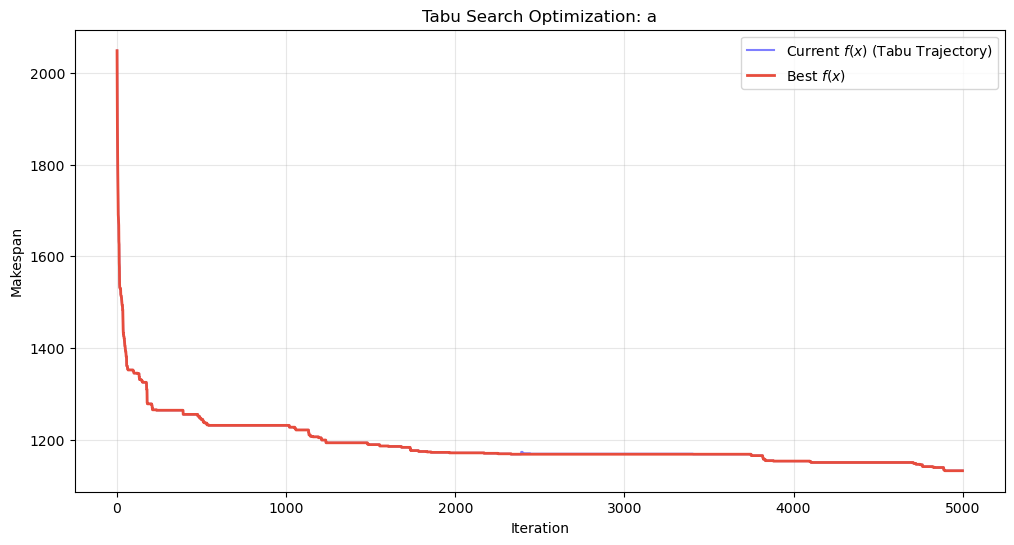

In [30]:
from jobshop_trajectory_based import*
import matplotlib.pyplot as plt
def run_tabu_test():
    INSTANCE_NAME = "a"
    FILENAME = "jobshop_hackathon_instance.txt"
    ITERATIONS = 5000
    TABU_SIZE = 30

    try:
        num_jobs, num_machines, data = parse_instance(FILENAME, INSTANCE_NAME)
    except Exception as e:
        print(f"Error: {e}")
        return

    print(f"--- Testing Tabu Search on {INSTANCE_NAME} ---")
    
    start_time = time.time()
    best_makespan, best_sequence, history_best_makespan, history_current_makespan = tabu_search(data, num_machines, num_jobs, ITERATIONS, TABU_SIZE)
    duration = time.time() - start_time
    print(f"Best Makespan: {best_makespan}")
    print(f"Best Sequence: {best_sequence}")
    print(f"Time: {duration:.2f}s")
   
    plt.figure(figsize=(12, 6))
    plt.plot(history_current_makespan, label='Current $f(x)$ (Tabu Trajectory)', color='blue', alpha=0.5)
    plt.plot(history_best_makespan, label='Best $f(x)$', color='#e74c3c', linewidth=2)
    plt.title(f'Tabu Search Optimization: {INSTANCE_NAME}')
    plt.xlabel('Iteration')
    plt.ylabel('Makespan')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

run_tabu_test()